In [1]:
from allensdk.core.cell_types_cache import CellTypesCache
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Produce Data

In [2]:
# Get data
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')
ephys_features = ctc.get_ephys_features()
cells = ctc.get_cells()
cells = {c['id']:c for c in cells}

# Get meta
ef_df = pd.DataFrame(ephys_features)

In [59]:
# Format data
exp, meta = [], []
samples = 256
sweep_num = 10
for sid in ef_df['specimen_id'][:samples]:
    data = ctc.get_ephys_data(sid)
    try:
        assert sweep_num in data.get_experiment_sweep_numbers()
    except:
        continue
    if cells[sid]['dendrite_type'] not in ['spiny', 'aspiny']:
        continue
    sweep = data.get_sweep(sweep_num)
    index_range = sweep["index_range"]
    sampling_rate = sweep["sampling_rate"]
    i = sweep["stimulus"][index_range[0]:index_range[1]+1] # in A
    v = sweep["response"][index_range[0]:index_range[1]+1] # in V
    i *= 1e12 # to pA
    v *= 1e3 # to mV
    t = np.arange(0, len(v)) * (1.0 / sampling_rate)
    exp.append({ 'time':t, 'stim':i, 'resp':v })
    meta.append([ cells[sid]['dendrite_type'] ])
meta = np.array(meta)

# Making the Model

In [60]:
import torch
from torch import nn

# Make model
class RNNModel(nn.Module):
    def __init__(self, h_in, h_out=20, num_layers=1, out_dim=1):
        super().__init__()
        
        self.h_in = h_in
        self.h_out = h_out
        self.num_layers = num_layers
        self.out_dim = out_dim
        
        self.rnn = nn.RNN(h_in, h_out, num_layers)
        self.fc = nn.Linear(h_out, out_dim)
        self.activation = nn.Sigmoid()
    
    def forward(self, X, return_out=False):
        h0 = torch.zeros(self.num_layers, self.h_out)
        out, hn = self.rnn(X, h0)
        Y = self.fc(hn)
        Y = self.activation(Y)
        if return_out:
            return Y, out
        return Y
    
    def run_all(self, X):
        logits = []
        for x in X:
            logits.append(self.forward(x))
        return torch.cat(logits, axis=0)
    
net = RNNModel(2)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=.001)
# Get data in proper format
dic, target = np.unique(meta[:, :1], return_inverse=True)
target = torch.Tensor(target.reshape((-1, 1)))
assert target.max() < 2

In [61]:
# Train
epochs = 20
batch_size = 64
subsample = 1000

for epoch in range(epochs):
    for batch in range(len(exp)//batch_size):
        # Get batch
        batch_idx = np.random.choice(len(exp), batch_size)
        stim, resp = [], []
        for i in batch_idx:
            stim.append(torch.Tensor(exp[i]['stim']))
            resp.append(torch.Tensor(exp[i]['resp']))
        inp = [torch.stack([st, re], axis=1)[::subsample] for st, re in zip(stim, resp)]
        
        # Get outputs
        logits = net.run_all(inp)
        true = target[batch_idx]
        
        # Loss
        loss = criterion(logits, true)
        
        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    # CLI
    print(f'Epoch: {epoch}  \tLoss: {float(loss.detach()):.5f}')

Epoch: 0  	Loss: 0.69838
Epoch: 1  	Loss: 0.68868
Epoch: 2  	Loss: 0.72267
Epoch: 3  	Loss: 0.69150
Epoch: 4  	Loss: 0.65643
Epoch: 5  	Loss: 0.67724
Epoch: 6  	Loss: 0.64244
Epoch: 7  	Loss: 0.69475
Epoch: 8  	Loss: 0.67351
Epoch: 9  	Loss: 0.67950
Epoch: 10  	Loss: 0.67709
Epoch: 11  	Loss: 0.69881
Epoch: 12  	Loss: 0.68175
Epoch: 13  	Loss: 0.68521
Epoch: 14  	Loss: 0.68221
Epoch: 15  	Loss: 0.70216
Epoch: 16  	Loss: 0.71815
Epoch: 17  	Loss: 0.69947
Epoch: 18  	Loss: 0.67268
Epoch: 19  	Loss: 0.67695


# Examples

In [62]:
stim, resp = [], []
for i in range(len(exp)):
    stim.append(torch.Tensor(exp[i]['stim']))
    resp.append(torch.Tensor(exp[i]['resp']))
inp = [torch.stack([st, re], axis=1)[::subsample] for st, re in zip(stim, resp)]
logits = net.run_all(inp)
logits = (logits > .5) * 1

In [ ]:
# np.unique(dic[logits], return_counts=True)[1]
# np.argwhere(dic[logits] == 'aspiny')

## Example 1

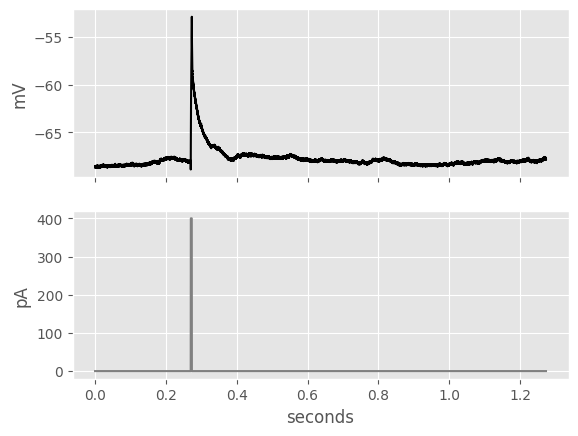

True:	['spiny']
Pred:	['spiny']


In [70]:
# Plot sample
plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, sharex=True)
sample = 25
axes[0].plot(exp[sample]['time'], exp[sample]['resp'], color='black')
axes[1].plot(exp[sample]['time'], exp[sample]['stim'], color='gray')
axes[0].set_ylabel("mV")
axes[1].set_ylabel("pA")
axes[1].set_xlabel("seconds")
plt.show()
print(f'True:\t{dic[(target > .5) * 1][sample]}\nPred:\t{dic[logits][sample]}')

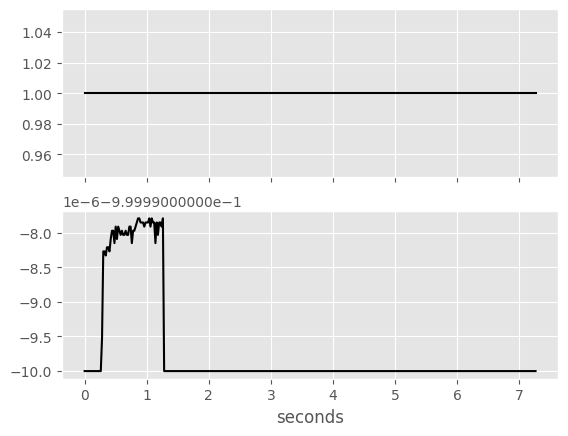

In [55]:
# Plot processed
plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, sharex=True)
sample = 25
_, out = net(torch.stack([torch.Tensor(exp[sample]['resp']), torch.Tensor(exp[sample]['stim'])], axis=1)[::subsample], return_out=True)
axes[0].plot(exp[sample]['time'][::subsample], out[:, 0].detach(), color='black')
axes[1].plot(exp[sample]['time'][::subsample], out[:, 2].detach(), color='black')
axes[0].set_ylabel(None)
axes[1].set_ylabel(None)
axes[1].set_xlabel("seconds")
plt.show()

## Example 2

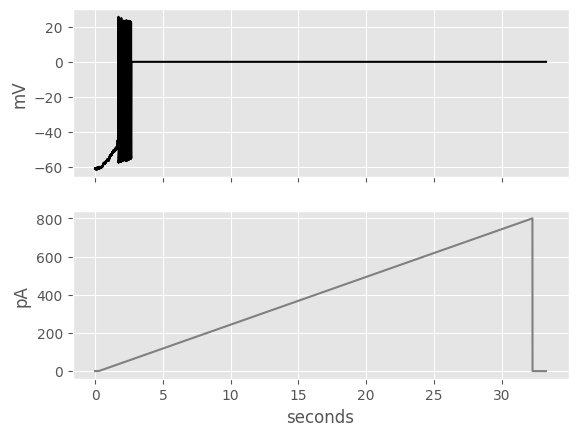

True:	['aspiny']
Pred:	['aspiny']


In [66]:
# Plot sample
plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, sharex=True)
sample = 39
axes[0].plot(exp[sample]['time'], exp[sample]['resp'], color='black')
axes[1].plot(exp[sample]['time'], exp[sample]['stim'], color='gray')
axes[0].set_ylabel("mV")
axes[1].set_ylabel("pA")
axes[1].set_xlabel("seconds")
plt.show()
print(f'True:\t{dic[(target > .5) * 1][sample]}\nPred:\t{dic[logits][sample]}')

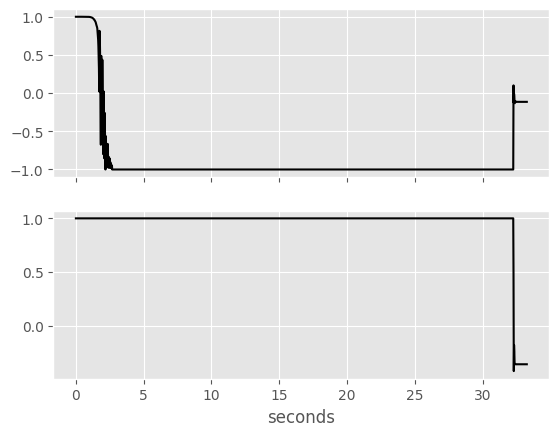

In [67]:
# Plot processed
plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, sharex=True)
sample = 39
_, out = net(torch.stack([torch.Tensor(exp[sample]['resp']), torch.Tensor(exp[sample]['stim'])], axis=1)[::subsample], return_out=True)
axes[0].plot(exp[sample]['time'][::subsample], out[:, 10].detach(), color='black')
axes[1].plot(exp[sample]['time'][::subsample], out[:, 12].detach(), color='black')
axes[0].set_ylabel(None)
axes[1].set_ylabel(None)
axes[1].set_xlabel("seconds")
plt.show()